### 2024/03/04 ラベル付け用の画像と表データの生成

In [1]:
import pandas as pd
import numpy as np
import requests
import math
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
import io

In [5]:
df = pd.read_pickle('../temp/20240301_box_t_rounded4_cossim.pkl')

In [6]:
drawing_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0)
    
url = [drawing_info.query('drawing_id == @drawing_id')['url'].iloc[-1] for drawing_id in df['drawing_id']]
rotate_type = [drawing_info.query('drawing_id == @drawing_id')['rotate_type'].iloc[-1] for drawing_id in df['drawing_id']]

df_annotation_form = pd.DataFrame({
    'drawing_id': df['drawing_id'],
    'stroke_id': df['stroke_id'],
    'shape': df['shape_str'],
    'length[mm]': df['len_mm'],
    'ptx[mm]': df['ptx_mm'],
    'pty[mm]': df['pty_mm'],
    'url': url,
    'rotate_type': rotate_type,
})

In [7]:
df_annotation_form.to_pickle('../temp/annotation_form_test.pkl')
df_annotation_form.to_excel('../temp/annotation_form_test.xlsx', encoding='shift-jis')

c:\Users\ispec\MyWorkSpace\python\drawing_2023\.venv\lib\site-packages\pandas\util\_decorators.py:211: FutureWarning: the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'
  return func(*args, **kwargs)


In [8]:
df_did_sid = pd.DataFrame({'drawing_id': df_annotation_form['drawing_id'], 
                           'stroke_id': df_annotation_form['stroke_id']})
df_did_sid.to_csv('../temp/drawingid_strokeid.csv', index=None)

##### ▶JSONファイルの生成

In [17]:
import json

df_did_sid = pd.read_csv('../temp/drawingid_strokeid.csv')
dict_did_sid = df_did_sid.to_dict(orient='records')

with open('../temp/20240308_annotation_form.json', 'w') as f:
    json.dump(dict_did_sid, f)

##### ▶ストローク座標から画像を生成

In [63]:
# URLを指定したドローイングの、指定した順番のストロークの形状を描画する関数
def draw_stroke(url, rotate_type, drawing_id, stroke_id, save_folder, canvas_color, stroke_color):
    class PreprocessedData():
        def __init__(self, url, rotate_type):
            self.CANVAS_HEIGHT = 297
            self.CANVAS_WIDTH = 420
            self.MAX_POINT = 943
            self.NORM_DIVISOR = 3
            self.columns = [ 'time', 'alpha', 'max_points', 'ptx_anoto', 'pty_anoto', 'shape_str',
                        'pressure_style', 'len_mm_acc', 'len_anoto', 'pressure_avg', 'shape_int']
            self.BIN_HEIGHT = 420
            self.BIN_WIDTH = 420
            
            self.df_org = None
            self.df_mm = None
            self.df_remove_overlap = None
            
            self.url = url
            self.rotate_type = rotate_type
            
            # urlからデータを作成
            self.get_df(self.url)
            self.conv_str_to_coord()

            self.remove_overlap_coord()
            ################################
            
        # URLからデータフレームを取得 & ストローク長の列を追加
        def get_df(self, url):
            content = requests.get(url, auth=('19t2003a', 'ireneRED77')).content
            df = pd.read_table(io.StringIO(content.decode('utf-8')), header = None)
            df.columns = self.columns
            st_len_mm = [l*0.3 for l in df['len_anoto']]
            df['len_mm'] = st_len_mm
            # ストローク固有のidを付与
            df_reindex = df.reset_index()
            df_reindex = df_reindex.rename(columns={'index': 'stroke_id'})
            
            self.df_org = df_reindex.copy()
            
        # 文字列座標データをリストに変換 & anotoから普通座標に変換
        def conv_str_to_coord(self):
            df = self.df_org.copy()
            x_list = []
            y_list = []
            for str_x, str_y in zip(df['ptx_anoto'], df['pty_anoto']):
                x_list.append([float(x)*0.3 for x in str_x.split(',')])
                y_list.append([float(y)*0.3 for y in str_y.split(',')])
            df['ptx_mm'] = x_list
            df['pty_mm'] = y_list
            self.df_mm = df
        
        # 重複している座標を排除
        def remove_overlap_coord(self):
            df = self.df_mm.copy()
            
            org_ptxs = df['ptx_mm']
            org_ptys = df['pty_mm']
            remove_indexs = []
            for ptxs, ptys in zip(org_ptxs, org_ptys):
                remove_index = []
                for i in range(1, len(ptxs)):
                    if ptxs[i] == ptxs[i-1] and ptys[i] == ptys[i-1]:
                        remove_index.append(i)
                    else:
                        pass
                remove_indexs.append(remove_index)
            
            df['remove_index'] = remove_indexs
            
            remove_overlap_ptxs = []
            remove_overlap_ptys = []
            for ptxs, ptys, remove_index in zip(org_ptxs, org_ptys, df['remove_index']):
                remove_overlap_ptx = [ ptxs[i] for i in range(len(ptxs)) if i not in remove_index]
                remove_overlap_pty = [ ptys[i] for i in range(len(ptys)) if i not in remove_index]
                remove_overlap_ptxs.append(remove_overlap_ptx)
                remove_overlap_ptys.append(remove_overlap_pty)    
            
            df['ptx_mm'] = remove_overlap_ptxs
            df['pty_mm'] = remove_overlap_ptys
            
            self.df_remove_overlap = df

    # --- グラフ描画 ---#
    data = PreprocessedData(url, rotate_type)
    df = data.df_remove_overlap
    
    CANVAS_COLOR = canvas_color
    STROKE_COLOR = stroke_color
    
    STROKE_WIDTH = 3
    SCALE = 0.02
    STROKE_SCALE = 1
    
    if rotate_type == 0 or rotate_type == 180:
        X_MIN = 0
        X_MAX = 420
        Y_MIN = 0
        Y_MAX = 297
    else:
        X_MIN = 0
        X_MAX = 297
        Y_MIN = 0
        Y_MAX = 420
    
    
    plt.rcParams['font.family'] = 'MS Gothic'
    fig, ax = plt.subplots(figsize=((X_MAX - X_MIN)*SCALE, (Y_MAX - Y_MIN)*SCALE), facecolor='white')
    ax.set_facecolor(CANVAS_COLOR)
    
    x = df.query('stroke_id == @stroke_id')['ptx_mm'].iloc[-1]
    y = df.query('stroke_id == @stroke_id')['pty_mm'].iloc[-1]
    shape = df.query('stroke_id == @stroke_id')['shape_int'].iloc[-1]
    
    # # 座標の始点を用紙の中心(X_MAX/2, Y_MAX/2)にする
    # x_plot = [(c - x[0])*STROKE_SCALE + (X_MAX-X_MIN)/2 for c in x]
    # y_plot = [(c - y[0])*STROKE_SCALE + (Y_MAX-Y_MIN)/2 for c in y]
    
    # 座標の外包矩形が接するように拡大する
    x_slide_ex = []
    y_slide_ex = []
    x_min, x_max, y_min, y_max = min(x), max(x), min(y), max(y)
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_slide = [float(c) - x_min for c in x]
    y_slide = [float(c) - y_min for c in y]
    
    # ストローク座標が1点しかない場合は，拡大はせず原点にスライドするだけ
    if x_range == 0 and y_range == 0:
        x_slide_ex = x_slide
        y_slide_ex = y_slide
    # ありえないが，一応，ストロークが寸分違わず垂直の場合を考慮
    elif x_range == 0:
        y_ratio = (Y_MAX - Y_MIN) / y_range
        x_slide_ex = [float(x) * y_ratio for x in x_slide]
        y_slide_ex = [float(y) * y_ratio for y in y_slide]
    # ありえないが，一応，ストロークが寸分違わず水平の場合を考慮
    elif y_range == 0 :
        x_ratio = (X_MAX - X_MIN) / x_range
        x_slide_ex = [float(x) * x_ratio for x in x_slide]
        y_slide_ex = [float(y) * x_ratio for y in y_slide]
    else :
        x_ratio = (X_MAX - X_MIN) / x_range
        y_ratio = (Y_MAX - Y_MIN) / y_range
        if x_ratio <= y_ratio :
            x_slide_ex = [float(x) * x_ratio for x in x_slide]
            y_slide_ex = [float(y) * x_ratio for y in y_slide]
        elif x_ratio > y_ratio :
            x_slide_ex = [float(x) * y_ratio for x in x_slide]
            y_slide_ex = [float(y) * y_ratio for y in y_slide]
        else :
            pass
        
    x_plot = x_slide_ex
    y_plot = y_slide_ex
    
    
    # 軸の大きさ
    MARGIN_MM = 5
    ax.set_xlim(X_MIN-MARGIN_MM, X_MAX+MARGIN_MM)
    ax.set_ylim(Y_MIN-MARGIN_MM, Y_MAX+MARGIN_MM)
    
    ax.plot(x_plot, y_plot, color=STROKE_COLOR, linewidth=STROKE_WIDTH)
    # ax.scatter(x_plot[1:], y_plot[1:], color=STROKE_COLOR, marker='o')
    ax.scatter(x_plot[:1], y_plot[:1], color='orange', s=200)
    
    title = f'{drawing_id}_{stroke_id}'
    ax.set_title(title)
    ax.invert_yaxis()
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, 
                    bottom=False, left=False, right=False, top=False)
    # plt.savefig(f'{save_folder}/{drawing_id}_{stroke_id}.png')
    plt.show()
    plt.close()
    return

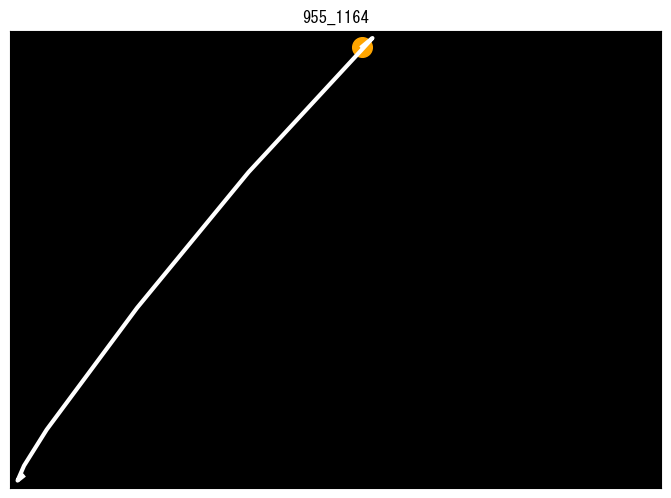

955 1164


In [64]:
# canvas_color = 'black'
# stroke_color = 'white'

# save_folder = '../temp/test'
# start = 1000
# end = 1001

# for url, rtype, did, sid in zip(
#     df_annotation_form[start:end]['url'], df_annotation_form[start:end]['rotate_type'], df_annotation_form[start:end]['drawing_id'], df_annotation_form[start:end]['stroke_id']):
#     draw_stroke(url, rtype, did, sid, save_folder, canvas_color, stroke_color)
#     print(did, sid)

### 2024/03/11 予備解析者の紙箱と紙袋のストローク画像の作成(線種ごと)

In [99]:
# # ドローイング情報
# drawing_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0)
# # --- 指導者 --- #
# box_t_info = drawing_info.query('is_preanalysis_box == 1').query('name == "saito"')
# bag_t_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "saito"')
# # --- 学習者 --- #
# box_a_info = drawing_info.query('is_preanalysis_box == 1').query('name == "井原亜利紗"')
# bag_a_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "井原亜利紗"')
# box_b_info = drawing_info.query('is_preanalysis_box == 1').query('name == "高田麻央"')
# bag_b_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "高田麻央"')
# box_c_info = drawing_info.query('is_preanalysis_box == 1').query('name == "冨山恭子"')
# bag_c_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "冨山恭子"')

In [3]:
# URLを指定したドローイングの、指定した順番のストロークの形状を描画する関数
def draw_stroke_all(url, rotate_type, drawing_id):
    class PreprocessedData():
        def __init__(self, url, rotate_type):
            self.CANVAS_HEIGHT = 297
            self.CANVAS_WIDTH = 420
            self.MAX_POINT = 943
            self.NORM_DIVISOR = 3
            self.columns = [ 'time', 'alpha', 'max_points', 'ptx_anoto', 'pty_anoto', 'shape_str',
                        'pressure_style', 'len_mm_acc', 'len_anoto', 'pressure_avg', 'shape_int']
            self.BIN_HEIGHT = 420
            self.BIN_WIDTH = 420
            
            self.df_org = None
            self.df_mm = None
            self.df_remove_overlap = None
            
            self.url = url
            self.rotate_type = rotate_type
            
            # urlからデータを作成
            self.get_df(self.url)
            self.conv_str_to_coord()

            self.remove_overlap_coord()
            ################################
            
        # URLからデータフレームを取得 & ストローク長の列を追加
        def get_df(self, url):
            content = requests.get(url, auth=('19t2003a', 'ireneRED77')).content
            df = pd.read_table(io.StringIO(content.decode('utf-8')), header = None)
            df.columns = self.columns
            st_len_mm = [l*0.3 for l in df['len_anoto']]
            df['len_mm'] = st_len_mm
            # ストローク固有のidを付与
            df_reindex = df.reset_index()
            df_reindex = df_reindex.rename(columns={'index': 'stroke_id'})
            
            self.df_org = df_reindex.copy()
            
        # 文字列座標データをリストに変換 & anotoから普通座標に変換
        def conv_str_to_coord(self):
            df = self.df_org.copy()
            x_list = []
            y_list = []
            for str_x, str_y in zip(df['ptx_anoto'], df['pty_anoto']):
                x_list.append([float(x)*0.3 for x in str_x.split(',')])
                y_list.append([float(y)*0.3 for y in str_y.split(',')])
            df['ptx_mm'] = x_list
            df['pty_mm'] = y_list
            self.df_mm = df
        
        # 重複している座標を排除
        def remove_overlap_coord(self):
            df = self.df_mm.copy()
            
            org_ptxs = df['ptx_mm']
            org_ptys = df['pty_mm']
            remove_indexs = []
            for ptxs, ptys in zip(org_ptxs, org_ptys):
                remove_index = []
                for i in range(1, len(ptxs)):
                    if ptxs[i] == ptxs[i-1] and ptys[i] == ptys[i-1]:
                        remove_index.append(i)
                    else:
                        pass
                remove_indexs.append(remove_index)
            
            df['remove_index'] = remove_indexs
            
            remove_overlap_ptxs = []
            remove_overlap_ptys = []
            for ptxs, ptys, remove_index in zip(org_ptxs, org_ptys, df['remove_index']):
                remove_overlap_ptx = [ ptxs[i] for i in range(len(ptxs)) if i not in remove_index]
                remove_overlap_pty = [ ptys[i] for i in range(len(ptys)) if i not in remove_index]
                remove_overlap_ptxs.append(remove_overlap_ptx)
                remove_overlap_ptys.append(remove_overlap_pty)    
            
            df['ptx_mm'] = remove_overlap_ptxs
            df['pty_mm'] = remove_overlap_ptys
            
            self.df_remove_overlap = df

    # --- グラフ描画 ---#
    data = PreprocessedData(url, rotate_type)
    df = data.df_remove_overlap
    
    STROKE_COLOR = 'black'
    STROKE_WIDTH = 2
    SCALE = 0.02
    STROKE_SCALE = 1
    
    if rotate_type == 0 or rotate_type == 180:
        X_MIN = 0
        X_MAX = 420
        Y_MIN = 0
        Y_MAX = 297
    else:
        X_MIN = 0
        X_MAX = 297
        Y_MIN = 0
        Y_MAX = 420
    
    
    plt.rcParams['font.family'] = 'MS Gothic'
    
    for x, y, stroke_id, shape_int in zip(df['ptx_mm'], df['pty_mm'], df['stroke_id'], df['shape_int']):
        fig, ax = plt.subplots(figsize=((X_MAX - X_MIN)*SCALE, (Y_MAX - Y_MIN)*SCALE), facecolor='white')
        
        # x = df.query('stroke_id == @stroke_id')['ptx_mm'].iloc[-1]
        # y = df.query('stroke_id == @stroke_id')['pty_mm'].iloc[-1]
        # shape = df.query('stroke_id == @stroke_id')['shape_int'].iloc[-1]
        
        # # 座標の始点を用紙の中心(X_MAX/2, Y_MAX/2)にする
        # x_plot = [(c - x[0])*STROKE_SCALE + (X_MAX-X_MIN)/2 for c in x]
        # y_plot = [(c - y[0])*STROKE_SCALE + (Y_MAX-Y_MIN)/2 for c in y]
        
        # 座標の外包矩形が接するように拡大する
        x_slide_ex = []
        y_slide_ex = []
        x_min, x_max, y_min, y_max = min(x), max(x), min(y), max(y)
        x_range = x_max - x_min
        y_range = y_max - y_min
        x_slide = [float(c) - x_min for c in x]
        y_slide = [float(c) - y_min for c in y]
        
        # ストローク座標が1点しかない場合は，拡大はせず原点にスライドするだけ
        if x_range == 0 and y_range == 0:
            x_slide_ex = x_slide
            y_slide_ex = y_slide
        # ありえないが，一応，ストロークが寸分違わず垂直の場合を考慮
        elif x_range == 0:
            y_ratio = (Y_MAX - Y_MIN) / y_range
            x_slide_ex = [float(x) * y_ratio for x in x_slide]
            y_slide_ex = [float(y) * y_ratio for y in y_slide]
        # ありえないが，一応，ストロークが寸分違わず水平の場合を考慮
        elif y_range == 0 :
            x_ratio = (X_MAX - X_MIN) / x_range
            x_slide_ex = [float(x) * x_ratio for x in x_slide]
            y_slide_ex = [float(y) * x_ratio for y in y_slide]
        else :
            x_ratio = (X_MAX - X_MIN) / x_range
            y_ratio = (Y_MAX - Y_MIN) / y_range
            if x_ratio <= y_ratio :
                x_slide_ex = [float(x) * x_ratio for x in x_slide]
                y_slide_ex = [float(y) * x_ratio for y in y_slide]
            elif x_ratio > y_ratio :
                x_slide_ex = [float(x) * y_ratio for x in x_slide]
                y_slide_ex = [float(y) * y_ratio for y in y_slide]
            else :
                pass
            
        x_plot = x_slide_ex
        y_plot = y_slide_ex
        
        
        # 軸の大きさ
        MARGIN_MM = 5
        ax.set_xlim(X_MIN-MARGIN_MM, X_MAX+MARGIN_MM)
        ax.set_ylim(Y_MIN-MARGIN_MM, Y_MAX+MARGIN_MM)
        
        ax.plot(x_plot, y_plot, color=STROKE_COLOR, linewidth=STROKE_WIDTH)
        # ax.scatter(x_plot[1:], y_plot[1:], color=STROKE_COLOR, marker='o')
        ax.scatter(x_plot[:1], y_plot[:1], color='orange', s=200)
        
        title = f'{drawing_id}_{stroke_id}'
        ax.set_title(title)
        ax.invert_yaxis()
        plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, 
                        bottom=False, left=False, right=False, top=False)
        
        if shape_int == 0:
            save_folder = '../temp/stroke_imgs/point'
        elif shape_int == 1:
            save_folder = '../temp/stroke_imgs/straight'
        elif shape_int == 2:
            save_folder = '../temp/stroke_imgs/curve'
        elif shape_int == 3:
            save_folder = '../temp/stroke_imgs/complex'
        elif shape_int == 4:
            save_folder = '../temp/stroke_imgs/hatching'
        else:
            print('error')
           
        plt.savefig(f'{save_folder}/{drawing_id}_{stroke_id}.png')
        # plt.show()
        plt.close()
        print(drawing_id, stroke_id)
    return

In [1]:
# # box_ct_info = pd.concat([box_c_info, box_t_info], axis=0)
# # bag_abct_info = pd.concat([bag_a_info, bag_b_info, bag_c_info, bag_t_info], axis=0)

# img_info = bag_t_info
# for times in range(len(img_info)):
#     url = img_info['url'][times:times+1].iloc[-1]
#     rotate_type = img_info['rotate_type'][times:times+1].iloc[-1]
#     drawing_id = img_info['drawing_id'][times:times+1].iloc[-1]
#     draw_stroke_all(url, rotate_type, drawing_id)

### 2024/03/12 アノテーションしてもらう線を決める(1000, 2000, 3000本)

In [2]:
def get_drawing_data(url, drawing_id, rotate_type, times):
    class DrawingData():
        def __init__(self, url, drawing_id, rotate_type, times):
            self.CANVAS_HEIGHT = 297
            self.CANVAS_WIDTH = 420
            self.MAX_POINT = 943
            self.NORM_DIVISOR = 3
            self.columns = [ 'time', 'alpha', 'max_points', 'ptx_anoto', 'pty_anoto', 'shape_str',
                        'pressure_style', 'len_mm_acc', 'len_anoto', 'pressure_avg', 'shape_int']
            self.BIN_HEIGHT = 420
            self.BIN_WIDTH = 420
            
            self.df_org = None
            self.df_mm = None
            
            self.url = url
            self.drawing_id = drawing_id
            self.rotate_type = rotate_type
            self.times = times
            
            # urlからデータを作成
            self.get_df(self.url)
            self.conv_str_to_coord()

            ################################
            
        # URLからデータフレームを取得 & ストローク長の列を追加
        def get_df(self, url):
            content = requests.get(url, auth=('19t2003a', 'ireneRED77')).content
            df = pd.read_table(io.StringIO(content.decode('utf-8')), header = None)
            df.columns = self.columns
            st_len_mm = [l*0.3 for l in df['len_anoto']]
            df['len_mm'] = st_len_mm
            # ストローク固有のidを付与
            df_reindex = df.reset_index()
            df_reindex = df_reindex.rename(columns={'index': 'stroke_id'})
            
            # ドローイングidの列を追加
            df_reindex['drawing_id'] = [self.drawing_id for i in range(len(df_reindex))]
            # 回数の列を追加
            df_reindex['times'] = [self.times for i in range(len(df_reindex))]
            
            self.df_org = df_reindex.copy()
            
        # 文字列座標データをリストに変換 & anotoから普通座標に変換
        def conv_str_to_coord(self):
            df = self.df_org.copy()
            x_list = []
            y_list = []
            for str_x, str_y in zip(df['ptx_anoto'], df['pty_anoto']):
                x_list.append([float(x)*0.3 for x in str_x.split(',')])
                y_list.append([float(y)*0.3 for y in str_y.split(',')])
            df['ptx_mm'] = x_list
            df['pty_mm'] = y_list
            self.df_mm = df
            
            
    data = DrawingData(url, drawing_id, rotate_type, times)
    
    return data.df_mm


In [3]:
### ドローイング情報 ############################################################################
drawing_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0)
# --- 指導者 --- #
box_t_info = drawing_info.query('is_preanalysis_box == 1').query('name == "saito"')
bag_t_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "saito"')
# --- 学習者 --- #
box_a_info = drawing_info.query('is_preanalysis_box == 1').query('name == "井原亜利紗"')
bag_a_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "井原亜利紗"')
box_b_info = drawing_info.query('is_preanalysis_box == 1').query('name == "高田麻央"')
bag_b_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "高田麻央"')
box_c_info = drawing_info.query('is_preanalysis_box == 1').query('name == "冨山恭子"')
bag_c_info = drawing_info.query('is_preanalysis_bag == 1').query('name == "冨山恭子"')

################################################################################################

# box
## A
box_a_each = [get_drawing_data(url, did, rtype, times) for url, did, rtype, times in zip(
    box_a_info['url'], box_a_info['drawing_id'], box_a_info['rotate_type'], box_a_info['times'])]
box_a = pd.concat(box_a_each, axis=0)
## B
box_b_each = [get_drawing_data(url, did, rtype, times) for url, did, rtype, times in zip(
    box_b_info['url'], box_b_info['drawing_id'], box_b_info['rotate_type'], box_b_info['times'])]
box_b = pd.concat(box_b_each, axis=0)
## C
box_c_each = [get_drawing_data(url, did, rtype, times) for url, did, rtype, times in zip(
    box_c_info['url'], box_c_info['drawing_id'], box_c_info['rotate_type'], box_c_info['times'])]
box_c = pd.concat(box_c_each, axis=0)

## T
box_t_each = [get_drawing_data(url, did, rtype, times) for url, did, rtype, times in zip(
    box_t_info['url'], box_t_info['drawing_id'], box_t_info['rotate_type'], box_t_info['times'])]
box_t = pd.concat(box_t_each, axis=0)


# bag
## A
bag_a_each = [get_drawing_data(url, did, rtype, times) for url, did, rtype, times in zip(
    bag_a_info['url'], bag_a_info['drawing_id'], bag_a_info['rotate_type'], bag_a_info['times'])]
bag_a = pd.concat(bag_a_each, axis=0)
## B
bag_b_each = [get_drawing_data(url, did, rtype, times) for url, did, rtype, times in zip(
    bag_b_info['url'], bag_b_info['drawing_id'], bag_b_info['rotate_type'], bag_b_info['times'])]
bag_b = pd.concat(bag_b_each, axis=0)
## C
bag_c_each = [get_drawing_data(url, did, rtype, times) for url, did, rtype, times in zip(
    bag_c_info['url'], bag_c_info['drawing_id'], bag_c_info['rotate_type'], bag_c_info['times'])]
bag_c = pd.concat(bag_c_each, axis=0)

## T
bag_t_each = [get_drawing_data(url, did, rtype, times) for url, did, rtype, times in zip(
    bag_t_info['url'], bag_t_info['drawing_id'], bag_t_info['rotate_type'], bag_t_info['times'])]
bag_t = pd.concat(bag_t_each, axis=0)


##### ▶予備解析対象者のすべての線における各線種の線の数

In [81]:
all_strokes = pd.concat([box_a, box_b, box_c, box_t, bag_a, bag_b, bag_c, bag_t])

In [85]:

print('全線種：', len(all_strokes))
print('点：', len(all_strokes.query('shape_int == 0')))
print('直線：', len(all_strokes.query('shape_int == 1')))
print('曲線：', len(all_strokes.query('shape_int == 2')))
print('複雑線：', len(all_strokes.query('shape_int == 3')))
print('ハッチング：', len(all_strokes.query('shape_int == 4')))

全線種： 46731
点： 2849
直線： 20763
曲線： 17985
複雑線： 3162
ハッチング： 1972


##### だいたい 直線, 曲線, 複雑線 = 47%, 41%, 12%

##### ▶データの生成（予備解析対象者、ランダムに抽出）

In [4]:
###############
seed = 1
n = 45
###############

# box
### A try
box_a_1_st = box_a.query('times == 1').query('shape_int == 1').sample(n=n, random_state=seed)
box_a_1_cu = box_a.query('times == 1').query('shape_int == 2').sample(n=n, random_state=seed)
box_a_1_ch = box_a.query('times == 1').query('shape_int >= 3').sample(n=n, random_state=seed)

box_a_2_st = box_a.query('times == 2').query('shape_int == 1').sample(n=n, random_state=seed)
box_a_2_cu = box_a.query('times == 2').query('shape_int == 2').sample(n=n, random_state=seed)
box_a_2_ch = box_a.query('times == 2').query('shape_int >= 3').sample(n=n, random_state=seed)


box_a_3_st = box_a.query('times == 3').query('shape_int == 1').sample(n=n, random_state=seed)
box_a_3_cu = box_a.query('times == 3').query('shape_int == 2').sample(n=n, random_state=seed)
box_a_3_ch = box_a.query('times == 3').query('shape_int >= 3').sample(n=n, random_state=seed)


### B try
box_b_1_st = box_b.query('times == 1').query('shape_int == 1').sample(n=n, random_state=seed)
box_b_1_cu = box_b.query('times == 1').query('shape_int == 2').sample(n=n, random_state=seed)
box_b_1_ch = box_b.query('times == 1').query('shape_int >= 3').sample(n=n, random_state=seed)


box_b_2_st = box_b.query('times == 2').query('shape_int == 1').sample(n=n, random_state=seed)
box_b_2_cu = box_b.query('times == 2').query('shape_int == 2').sample(n=n, random_state=seed)
box_b_2_ch = box_b.query('times == 2').query('shape_int >= 3').sample(n=n, random_state=seed)


box_b_3_st = box_b.query('times == 3').query('shape_int == 1').sample(n=n, random_state=seed)
box_b_3_cu = box_b.query('times == 3').query('shape_int == 2').sample(n=n, random_state=seed)
box_b_3_ch = box_b.query('times == 3').query('shape_int >= 3').sample(n=n, random_state=seed)


### C try
box_c_1_st = box_c.query('times == 1').query('shape_int == 1').sample(n=n, random_state=seed)
box_c_1_cu = box_c.query('times == 1').query('shape_int == 2').sample(n=n, random_state=seed)
box_c_1_ch = box_c.query('times == 1').query('shape_int >= 3').sample(n=n, random_state=seed)


box_c_2_st = box_c.query('times == 2').query('shape_int == 1').sample(n=n, random_state=seed)
box_c_2_cu = box_c.query('times == 2').query('shape_int == 2').sample(n=n, random_state=seed)
box_c_2_ch = box_c.query('times == 2').query('shape_int >= 3').sample(n=n, random_state=seed)


box_c_3_st = box_c.query('times == 3').query('shape_int == 1').sample(n=n, random_state=seed)
box_c_3_cu = box_c.query('times == 3').query('shape_int == 2').sample(n=n, random_state=seed)
box_c_3_ch = box_c.query('times == 3').query('shape_int >= 3').sample(n=n, random_state=seed)


### T try
box_t_1_st = box_t.query('times == 1').query('shape_int == 1').sample(n=n, random_state=seed)
box_t_1_cu = box_t.query('times == 1').query('shape_int == 2').sample(n=n, random_state=seed)
box_t_1_ch = box_t.query('times == 1').query('shape_int >= 3').sample(n=n, random_state=seed)


box_t_2_st = box_t.query('times == 2').query('shape_int == 1').sample(n=n, random_state=seed)
box_t_2_cu = box_t.query('times == 2').query('shape_int == 2').sample(n=n, random_state=seed)
box_t_2_ch = box_t.query('times == 2').query('shape_int >= 3').sample(n=n, random_state=seed)


box_t_3_st = box_t.query('times == 3').query('shape_int == 1').sample(n=n, random_state=seed)
box_t_3_cu = box_t.query('times == 3').query('shape_int == 2').sample(n=n, random_state=seed)
box_t_3_ch = box_t.query('times == 3').query('shape_int >= 3').sample(n=n, random_state=seed)


box_t_4_st = box_t.query('times == 4').query('shape_int == 1').sample(n=n, random_state=seed)
box_t_4_cu = box_t.query('times == 4').query('shape_int == 2').sample(n=n, random_state=seed)
box_t_4_ch = box_t.query('times == 4').query('shape_int >= 3').sample(n=n, random_state=seed)

# bag
### A try
bag_a_1_st = bag_a.query('times == 1').query('shape_int == 1').sample(n=n, random_state=seed)
bag_a_1_cu = bag_a.query('times == 1').query('shape_int == 2').sample(n=n, random_state=seed)
bag_a_1_ch = bag_a.query('times == 1').query('shape_int >= 3').sample(n=n, random_state=seed)


bag_a_2_st = bag_a.query('times == 2').query('shape_int == 1').sample(n=n, random_state=seed)
bag_a_2_cu = bag_a.query('times == 2').query('shape_int == 2').sample(n=n, random_state=seed)
bag_a_2_ch = bag_a.query('times == 2').query('shape_int >= 3').sample(n=n, random_state=seed)


bag_a_3_st = bag_a.query('times == 3').query('shape_int == 1').sample(n=n, random_state=seed)
bag_a_3_cu = bag_a.query('times == 3').query('shape_int == 2').sample(n=n, random_state=seed)
bag_a_3_ch = bag_a.query('times == 3').query('shape_int >= 3').sample(n=n, random_state=seed)


### B try
bag_b_1_st = bag_b.query('times == 1').query('shape_int == 1').sample(n=n, random_state=seed)
bag_b_1_cu = bag_b.query('times == 1').query('shape_int == 2').sample(n=n, random_state=seed)
bag_b_1_ch = bag_b.query('times == 1').query('shape_int >= 3').sample(n=n, random_state=seed)


bag_b_2_st = bag_b.query('times == 2').query('shape_int == 1').sample(n=n, random_state=seed)
bag_b_2_cu = bag_b.query('times == 2').query('shape_int == 2').sample(n=n, random_state=seed)
bag_b_2_ch = bag_b.query('times == 2').query('shape_int >= 3').sample(n=n, random_state=seed)


bag_b_3_st = bag_b.query('times == 3').query('shape_int == 1').sample(n=n, random_state=seed)
bag_b_3_cu = bag_b.query('times == 3').query('shape_int == 2').sample(n=n, random_state=seed)
bag_b_3_ch = bag_b.query('times == 3').query('shape_int >= 3').sample(n=n, random_state=seed)


### C try
bag_c_1_st = bag_c.query('times == 1').query('shape_int == 1').sample(n=n, random_state=seed)
bag_c_1_cu = bag_c.query('times == 1').query('shape_int == 2').sample(n=n, random_state=seed)
bag_c_1_ch = bag_c.query('times == 1').query('shape_int >= 3').sample(n=n, random_state=seed)


bag_c_2_st = bag_c.query('times == 2').query('shape_int == 1').sample(n=n, random_state=seed)
bag_c_2_cu = bag_c.query('times == 2').query('shape_int == 2').sample(n=n, random_state=seed)
bag_c_2_ch = bag_c.query('times == 2').query('shape_int >= 3').sample(n=n, random_state=seed)


### T try
bag_t_1_st = bag_t.query('times == 1').query('shape_int == 1').sample(n=n, random_state=seed)
bag_t_1_cu = bag_t.query('times == 1').query('shape_int == 2').sample(n=n, random_state=seed)
bag_t_1_ch = bag_t.query('times == 1').query('shape_int >= 3').sample(n=n, random_state=seed)


bag_t_2_st = bag_t.query('times == 2').query('shape_int == 1').sample(n=n, random_state=seed)
bag_t_2_cu = bag_t.query('times == 2').query('shape_int == 2').sample(n=n, random_state=seed)
bag_t_2_ch = bag_t.query('times == 2').query('shape_int >= 3').sample(n=n, random_state=seed)


In [5]:
annotation_seed1 = pd.concat([box_a_1_st, box_a_1_cu, box_a_1_ch,
                            box_a_2_st, box_a_2_cu, box_a_2_ch,
                            box_a_3_st, box_a_3_cu, box_a_3_ch, 
                            box_b_1_st, box_b_1_cu, box_b_1_ch,
                            box_b_2_st, box_b_2_cu, box_b_2_ch,
                            box_b_3_st, box_b_3_cu, box_b_3_ch,
                            box_c_1_st, box_c_1_cu, box_c_1_ch,
                            box_c_2_st, box_c_2_cu, box_c_2_ch,
                            box_c_3_st, box_c_3_cu, box_c_3_ch,
                            box_t_1_st, box_t_1_cu, box_t_1_ch,
                            box_t_2_st, box_t_2_cu, box_t_2_ch,
                            box_t_3_st, box_t_3_cu, box_t_3_ch, 
                            box_t_4_st, box_t_4_cu, box_t_4_ch,
                            bag_a_1_st, bag_a_1_cu, bag_a_1_ch, 
                            bag_a_2_st, bag_a_2_cu, bag_a_2_ch,
                            bag_a_3_st, bag_a_3_cu, bag_a_3_ch,
                            bag_b_1_st, bag_b_1_cu, bag_b_1_ch,
                            bag_b_2_st, bag_b_2_cu, bag_b_2_ch,
                            bag_b_3_st, bag_b_3_cu, bag_b_3_ch,
                            bag_c_1_st, bag_c_1_cu, bag_c_1_ch,
                            bag_c_2_st, bag_c_2_cu, bag_c_2_ch,
                            bag_t_1_st, bag_t_1_cu, bag_t_1_ch,
                            bag_t_2_st, bag_t_2_cu, bag_t_2_ch
                            ])

annotation_seed1_didsid = pd.DataFrame({'drawing_id': annotation_seed1['drawing_id'],
                                        'stroke_id': annotation_seed1['stroke_id']})

In [7]:
print(len(annotation_seed1.query('shape_int == 1')))
print(len(annotation_seed1.query('shape_int == 2')))
print(len(annotation_seed1.query('shape_int >= 3')))

1035
1035
1035


##### ▶画像の生成

In [8]:
# URLを指定したドローイングの、指定した順番のストロークの形状を描画する関数
def draw_one_stroke(url, rotate_type, drawing_id, stroke_id):
    class PreprocessedData():
        def __init__(self, url, rotate_type):
            self.CANVAS_HEIGHT = 297
            self.CANVAS_WIDTH = 420
            self.MAX_POINT = 943
            self.NORM_DIVISOR = 3
            self.columns = [ 'time', 'alpha', 'max_points', 'ptx_anoto', 'pty_anoto', 'shape_str',
                        'pressure_style', 'len_mm_acc', 'len_anoto', 'pressure_avg', 'shape_int']
            self.BIN_HEIGHT = 420
            self.BIN_WIDTH = 420
            
            self.df_org = None
            self.df_mm = None
            self.df_remove_overlap = None
            
            self.url = url
            self.rotate_type = rotate_type
            
            # urlからデータを作成
            self.get_df(self.url)
            self.conv_str_to_coord()

            self.remove_overlap_coord()
            ################################
            
        # URLからデータフレームを取得 & ストローク長の列を追加
        def get_df(self, url):
            content = requests.get(url, auth=('19t2003a', 'ireneRED77')).content
            df = pd.read_table(io.StringIO(content.decode('utf-8')), header = None)
            df.columns = self.columns
            st_len_mm = [l*0.3 for l in df['len_anoto']]
            df['len_mm'] = st_len_mm
            # ストローク固有のidを付与
            df_reindex = df.reset_index()
            df_reindex = df_reindex.rename(columns={'index': 'stroke_id'})
            
            self.df_org = df_reindex.copy()
            
        # 文字列座標データをリストに変換 & anotoから普通座標に変換
        def conv_str_to_coord(self):
            df = self.df_org.copy()
            x_list = []
            y_list = []
            for str_x, str_y in zip(df['ptx_anoto'], df['pty_anoto']):
                x_list.append([float(x)*0.3 for x in str_x.split(',')])
                y_list.append([float(y)*0.3 for y in str_y.split(',')])
            df['ptx_mm'] = x_list
            df['pty_mm'] = y_list
            self.df_mm = df
        
        # 重複している座標を排除
        def remove_overlap_coord(self):
            df = self.df_mm.copy()
            
            org_ptxs = df['ptx_mm']
            org_ptys = df['pty_mm']
            remove_indexs = []
            for ptxs, ptys in zip(org_ptxs, org_ptys):
                remove_index = []
                for i in range(1, len(ptxs)):
                    if ptxs[i] == ptxs[i-1] and ptys[i] == ptys[i-1]:
                        remove_index.append(i)
                    else:
                        pass
                remove_indexs.append(remove_index)
            
            df['remove_index'] = remove_indexs
            
            remove_overlap_ptxs = []
            remove_overlap_ptys = []
            for ptxs, ptys, remove_index in zip(org_ptxs, org_ptys, df['remove_index']):
                remove_overlap_ptx = [ ptxs[i] for i in range(len(ptxs)) if i not in remove_index]
                remove_overlap_pty = [ ptys[i] for i in range(len(ptys)) if i not in remove_index]
                remove_overlap_ptxs.append(remove_overlap_ptx)
                remove_overlap_ptys.append(remove_overlap_pty)    
            
            df['ptx_mm'] = remove_overlap_ptxs
            df['pty_mm'] = remove_overlap_ptys
            
            self.df_remove_overlap = df

    # --- グラフ描画 ---#
    data = PreprocessedData(url, rotate_type)
    df = data.df_remove_overlap
    
    CANVAS_COLOR = 'black'
    STROKE_COLOR = 'white'
    
    STROKE_WIDTH = 3
    SCALE = 0.02
    STROKE_SCALE = 1
    
    if rotate_type == 0 or rotate_type == 180:
        X_MIN = 0
        X_MAX = 420
        Y_MIN = 0
        Y_MAX = 297
    else:
        X_MIN = 0
        X_MAX = 297
        Y_MIN = 0
        Y_MAX = 420
    
    
    plt.rcParams['font.family'] = 'MS Gothic'
    fig, ax = plt.subplots(figsize=((X_MAX - X_MIN)*SCALE, (Y_MAX - Y_MIN)*SCALE), facecolor='white')
    ax.set_facecolor(CANVAS_COLOR)
    
    x = df.query('stroke_id == @stroke_id')['ptx_mm'].iloc[-1]
    y = df.query('stroke_id == @stroke_id')['pty_mm'].iloc[-1]
    shape_int = df.query('stroke_id == @stroke_id')['shape_int'].iloc[-1]
    
    # # 座標の始点を用紙の中心(X_MAX/2, Y_MAX/2)にする
    # x_plot = [(c - x[0])*STROKE_SCALE + (X_MAX-X_MIN)/2 for c in x]
    # y_plot = [(c - y[0])*STROKE_SCALE + (Y_MAX-Y_MIN)/2 for c in y]
    
    # 座標の外包矩形が接するように拡大する
    x_slide_ex = []
    y_slide_ex = []
    x_min, x_max, y_min, y_max = min(x), max(x), min(y), max(y)
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_slide = [float(c) - x_min for c in x]
    y_slide = [float(c) - y_min for c in y]
    
    # ストローク座標が1点しかない場合は，拡大はせず原点にスライドするだけ
    if x_range == 0 and y_range == 0:
        x_slide_ex = x_slide
        y_slide_ex = y_slide
    # ありえないが，一応，ストロークが寸分違わず垂直の場合を考慮
    elif x_range == 0:
        y_ratio = (Y_MAX - Y_MIN) / y_range
        x_slide_ex = [float(x) * y_ratio for x in x_slide]
        y_slide_ex = [float(y) * y_ratio for y in y_slide]
    # ありえないが，一応，ストロークが寸分違わず水平の場合を考慮
    elif y_range == 0 :
        x_ratio = (X_MAX - X_MIN) / x_range
        x_slide_ex = [float(x) * x_ratio for x in x_slide]
        y_slide_ex = [float(y) * x_ratio for y in y_slide]
    else :
        x_ratio = (X_MAX - X_MIN) / x_range
        y_ratio = (Y_MAX - Y_MIN) / y_range
        if x_ratio <= y_ratio :
            x_slide_ex = [float(x) * x_ratio for x in x_slide]
            y_slide_ex = [float(y) * x_ratio for y in y_slide]
        elif x_ratio > y_ratio :
            x_slide_ex = [float(x) * y_ratio for x in x_slide]
            y_slide_ex = [float(y) * y_ratio for y in y_slide]
        else :
            pass
        
    x_plot = x_slide_ex
    y_plot = y_slide_ex
    
    
    # 軸の大きさ
    MARGIN_MM = 5
    ax.set_xlim(X_MIN-MARGIN_MM, X_MAX+MARGIN_MM)
    ax.set_ylim(Y_MIN-MARGIN_MM, Y_MAX+MARGIN_MM)
    
    ax.plot(x_plot, y_plot, color=STROKE_COLOR, linewidth=STROKE_WIDTH)
    # ax.scatter(x_plot[1:], y_plot[1:], color=STROKE_COLOR, marker='o')
    ax.scatter(x_plot[:1], y_plot[:1], color='orange', s=200)
    
    title = f'{drawing_id}_{stroke_id}'
    ax.set_title(title)
    ax.invert_yaxis()
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False, 
                    bottom=False, left=False, right=False, top=False)
    if shape_int == 0:
        save_folder = '../temp/stroke_imgs/point'
    elif shape_int == 1:
        save_folder = '../temp/stroke_imgs/straight'
    elif shape_int == 2:
        save_folder = '../temp/stroke_imgs/curve'
    elif shape_int == 3:
        save_folder = '../temp/stroke_imgs/complex'
    elif shape_int == 4:
        save_folder = '../temp/stroke_imgs/hatching'
    else:
        print('error')
        
    plt.savefig(f'{save_folder}/{drawing_id}_{stroke_id}.png')
    # plt.show()
    plt.close()
    return

In [9]:
cnt = 0
drawing_info = pd.read_excel('../data/all_drawing_info.xlsx', index_col=0)
for did, sid in zip(annotation_seed1_didsid['drawing_id'], annotation_seed1_didsid['stroke_id']):
    url = drawing_info.query('drawing_id == @did')['url'].iloc[-1]
    rotate_type = drawing_info.query('drawing_id == @did')['rotate_type'].iloc[-1]
    draw_one_stroke(url, rotate_type, did, sid)
    
    cnt += 1
    print(cnt)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
